In [1]:
# Run validation if needed
# ! python validate.py --config_path 'configs/lr_config.yaml' --model 'GCN' --model_path 'saved_models/gcn/GCN_for_lrp01_2025-05-04_18-43-34.pt' --output_dir 'saved_metrics/gcn'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Specific Model

In [3]:
saved_metrics_path = 'saved_metrics/lr/swegnn/SWEGNN_lrp01_metrics.npz'
saved_metrics = np.load(saved_metrics_path, allow_pickle=True)
rmse = saved_metrics['rmse']
mae = saved_metrics['mae']
nse = saved_metrics['nse']
csi = saved_metrics['csi']
pred = saved_metrics['pred']

In [4]:
print('RMSE:', np.mean(rmse))
print('MAE:', np.mean(mae))
print('NSE:', np.mean(nse))
print('CSI:', np.mean(csi))
print('Pred shape:', pred.shape)

RMSE: 0.63842005
MAE: 0.15356757
NSE: -0.059208445
CSI: 0.08504971
Pred shape: (576, 22551, 1)


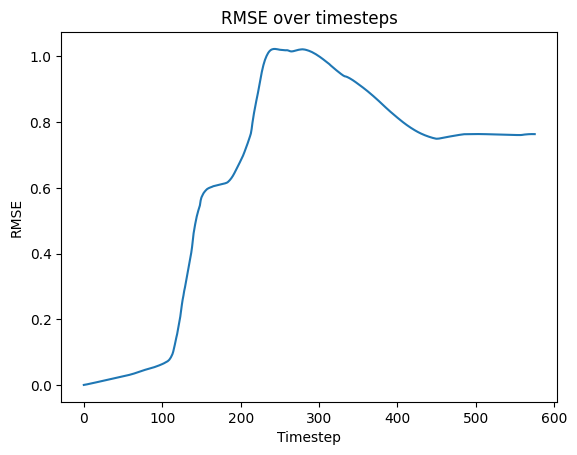

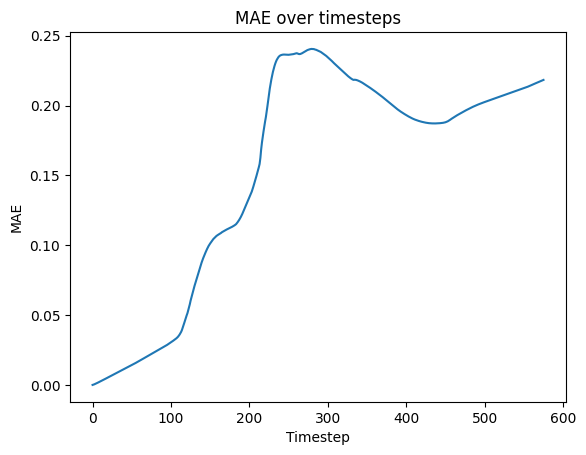

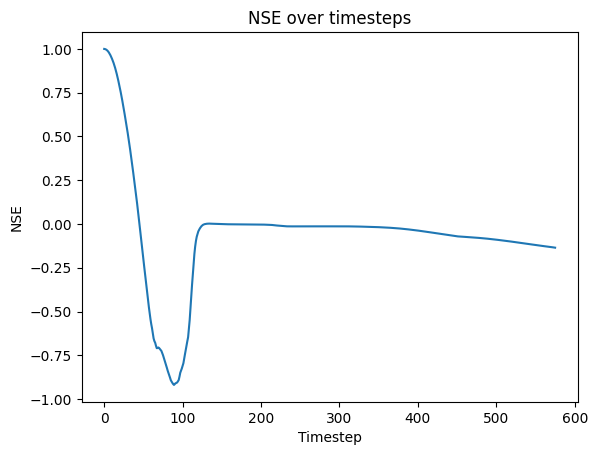

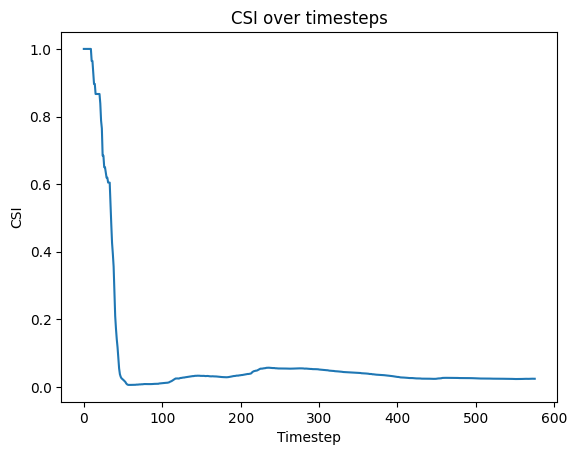

In [5]:
def plot(x, xlabel, ylabel, title):
    plt.plot(x)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

plot(rmse, xlabel='Timestep', ylabel='RMSE', title='RMSE over timesteps')
plot(mae, xlabel='Timestep', ylabel='MAE', title='MAE over timesteps')
plot(nse, xlabel='Timestep', ylabel='NSE', title='NSE over timesteps')
plot(csi, xlabel='Timestep', ylabel='CSI', title='CSI over timesteps')

In [6]:
rmse_flooded = saved_metrics['rmse_flooded']
mae_flooded = saved_metrics['mae_flooded']
nse_flooded = saved_metrics['nse_flooded']

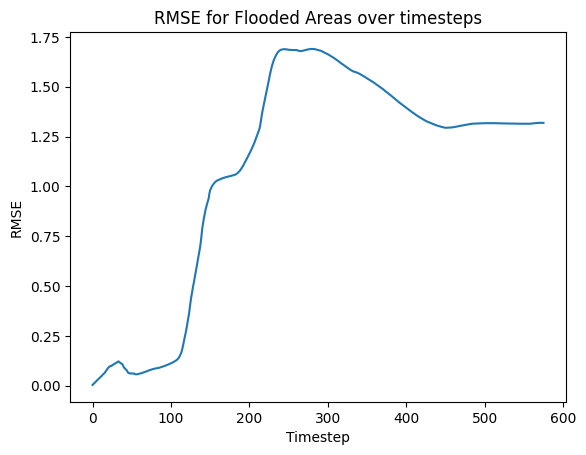

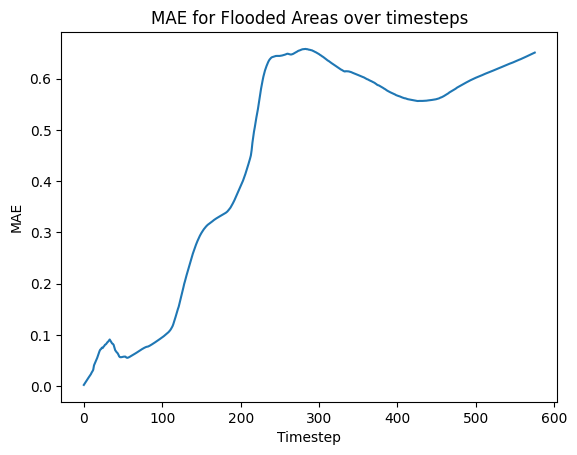

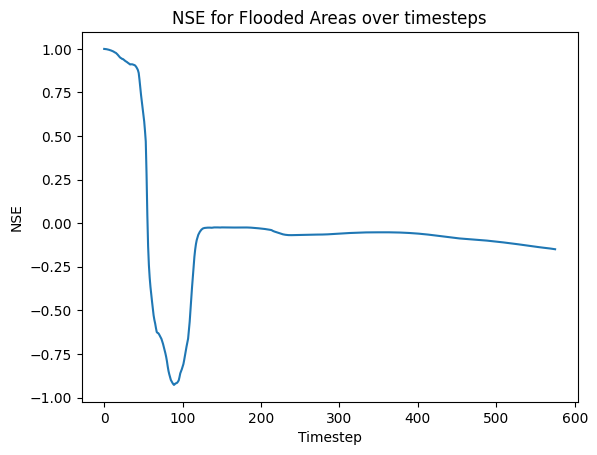

In [7]:
plot(rmse_flooded, xlabel='Timestep', ylabel='RMSE', title='RMSE for Flooded Areas over timesteps')
plot(mae_flooded, xlabel='Timestep', ylabel='MAE', title='MAE for Flooded Areas over timesteps')
plot(nse_flooded, xlabel='Timestep', ylabel='NSE', title='NSE for Flooded Areas over timesteps')

### Comparison

In [8]:
metric_paths = [
    'saved_metrics/init/gcn/GCN_initp01_metrics.npz',
    'saved_metrics/init/gat/GAT_initp01_metrics.npz',
    'saved_metrics/init/gin/GIN_initp01_metrics.npz',
    'saved_metrics/init/swegnn/SWEGNN_initp01_metrics.npz',
]
# metric_paths = [
#     'saved_metrics/lr/gcn/GCN_lrp01_metrics.npz',
#     'saved_metrics/lr/gat/GAT_lrp01_metrics.npz',
#     'saved_metrics/lr/gin/GIN_lrp01_metrics.npz',
#     'saved_metrics/lr/swegnn/SWEGNN_lrp01_metrics.npz',
# ]
# metric_paths = [
#     'saved_metrics/lr/gcn/GCN_lrp04_metrics.npz',
#     'saved_metrics/lr/gat/GAT_lrp04_metrics.npz',
#     'saved_metrics/lr/gin/GIN_lrp04_metrics.npz',
#     'saved_metrics/lr/swegnn/SWEGNN_lrp04_metrics.npz',
# ]
# metric_paths = [
#     'saved_metrics/lr/gcn/GCN_lrp05_metrics.npz',
#     'saved_metrics/lr/gat/GAT_lrp05_metrics.npz',
#     'saved_metrics/lr/gin/GIN_lrp05_metrics.npz',
#     'saved_metrics/lr/swegnn/SWEGNN_lrp05_metrics.npz',
# ]
# metric_paths = [
#     'saved_metrics/lr/gcn/GCN_lrp08_metrics.npz',
#     'saved_metrics/lr/gat/GAT_lrp08_metrics.npz',
#     'saved_metrics/lr/gin/GIN_lrp08_metrics.npz',
#     'saved_metrics/lr/swegnn/SWEGNN_lrp08_metrics.npz',
# ]


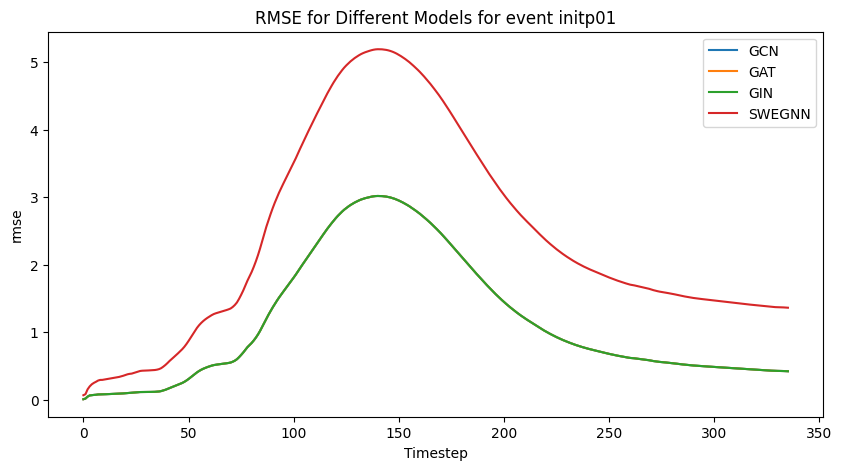

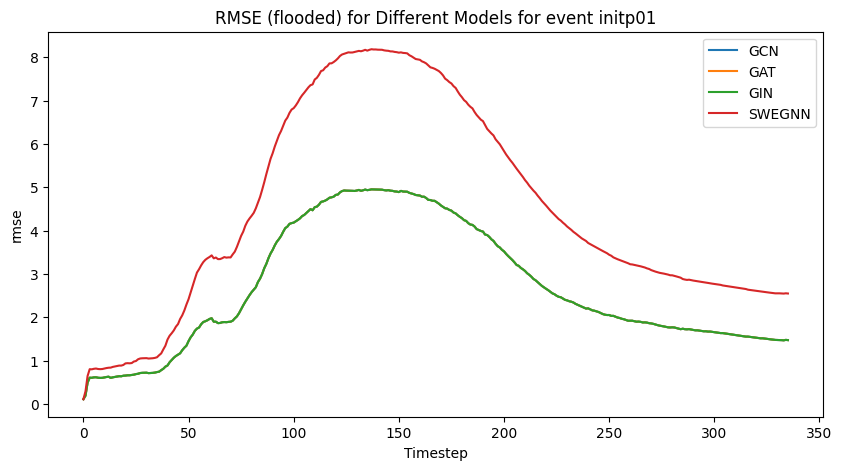

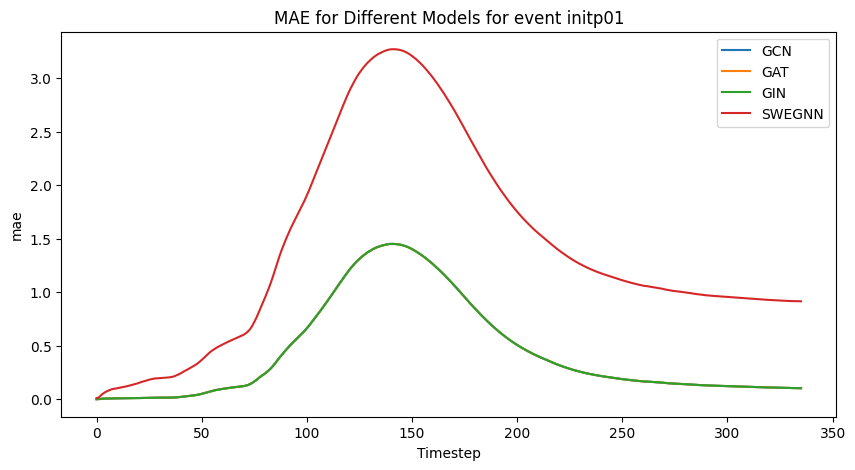

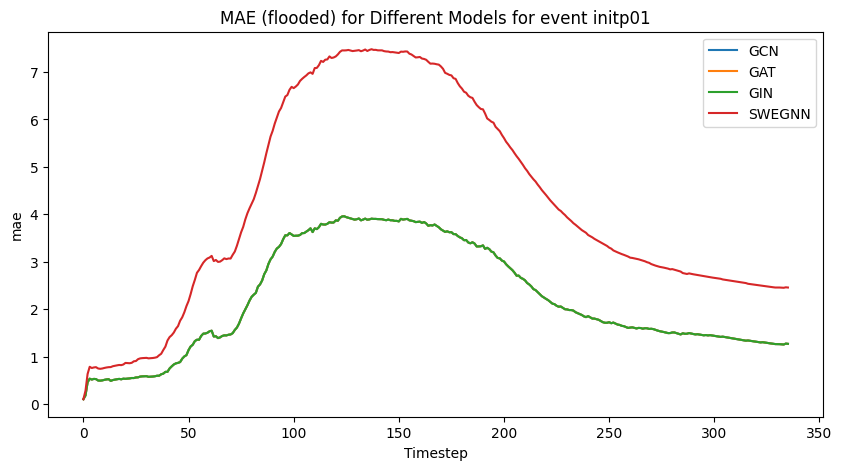

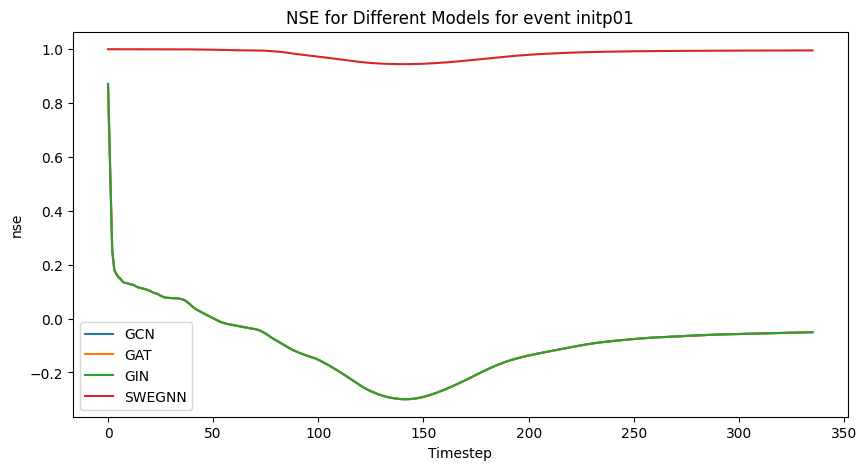

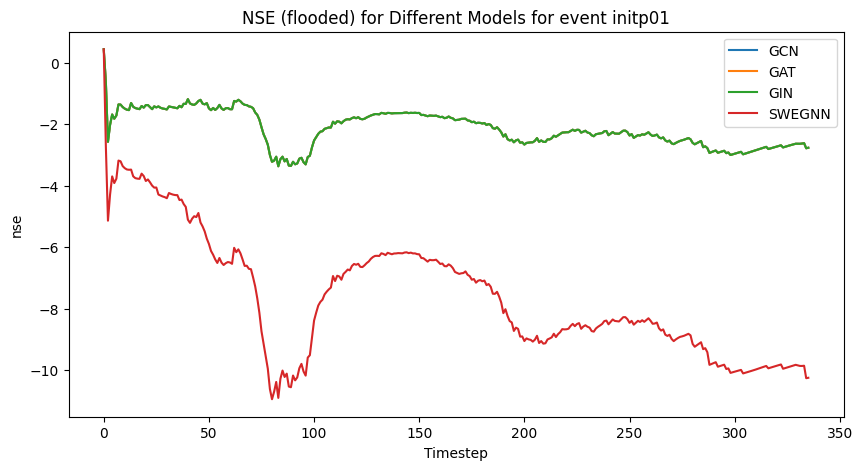

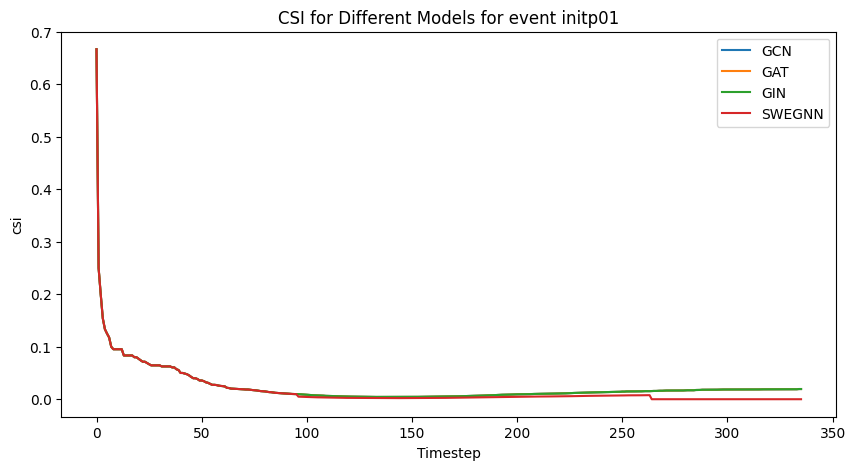

In [9]:
def plot_metric_for_all_models(metric_paths: list[str], metric: str):
    split_metric = metric.split('_') 
    metric_name = split_metric[0].upper() + (f' ({split_metric[1]})' if len(split_metric) > 1 else '')
    event_name = metric_paths[0].split('/')[-1].split('_')[1]

    plt.figure(figsize=(10, 5))
    plt.title(f'{metric_name} for Different Models for event {event_name}')
    plt.xlabel('Timestep')
    plt.ylabel(split_metric[0])

    data_shape = None
    for path in metric_paths:
        label = path.split('/')[-1].split('_')[0]
        data = np.load(path, allow_pickle=True)[metric]
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for model {label}: {data.shape} vs {data_shape}"

        plt.plot(data, label=label)

    plt.legend()
    plt.show()

plot_metric_for_all_models(metric_paths, 'rmse')
plot_metric_for_all_models(metric_paths, 'rmse_flooded')
plot_metric_for_all_models(metric_paths, 'mae')
plot_metric_for_all_models(metric_paths, 'mae_flooded')
plot_metric_for_all_models(metric_paths, 'nse')
plot_metric_for_all_models(metric_paths, 'nse_flooded')
plot_metric_for_all_models(metric_paths, 'csi')

In [14]:
import torch
from data.hecras_data_retrieval import get_water_level
from data.shp_data_retrieval import get_cell_elevation

# hecras_path = 'data/datasets/lr/lrp01/raw/M01.p01.hdf'
# node_shp_path = 'data/datasets/lr/lrp01/raw/cell_centers.shp'
hecras_path = 'data/datasets/init/initp01/raw/Model_01.p01.hdf'
node_shp_path = 'data/datasets/init/initp01/raw/cell_centers.shp'

water_level = torch.from_numpy(get_water_level(hecras_path))
cell_elevation = torch.from_numpy(get_cell_elevation(node_shp_path))
water_depth = torch.clip(water_level - cell_elevation, min=0)

print(water_depth.shape)

torch.Size([337, 1268])


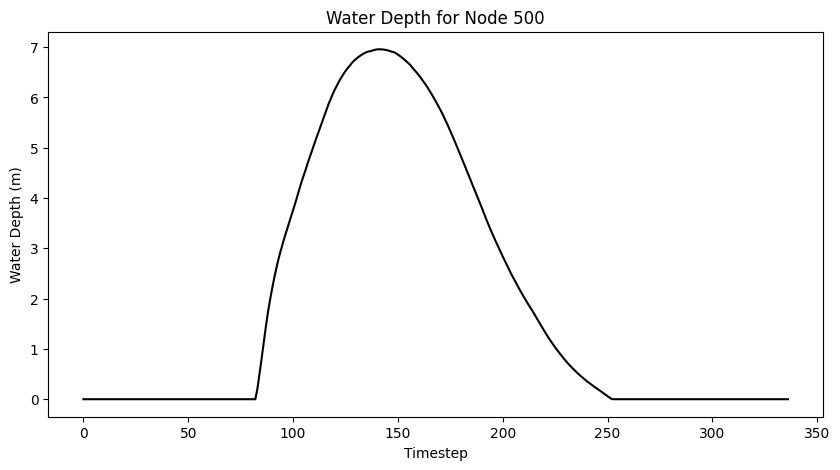

Peak water depth for node 500: 6.95782470703125 (timestep 141)


In [22]:
NODE_IDX = 500
# NODE_IDX = 3536 # Upstream node index
# NODE_IDX = 10593 # Midstream node index
# NODE_IDX = 17686 # Downstream node index

def plot_water_depth_for_node(node_idx: int, water_depth: torch.Tensor):
    plt.figure(figsize=(10, 5))
    plt.title(f'Water Depth for Node {node_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Depth (m)')
    plt.plot(water_depth[:, node_idx].numpy(), color='black')
    plt.show()

plot_water_depth_for_node(NODE_IDX, water_depth)
peak_wd = water_depth[:, NODE_IDX].max()
peak_wd_timestep = water_depth[:, NODE_IDX].argmax()
print(f"Peak water depth for node {NODE_IDX}: {peak_wd} (timestep {peak_wd_timestep})")

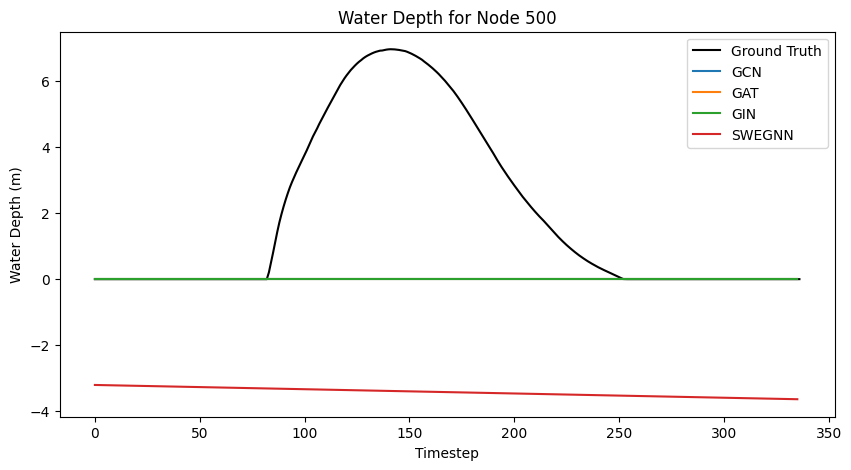

In [23]:
def plot_node_water_depth_for_all_models(metric_paths: list[str], node_idx: int, ground_truth: torch.Tensor = None):
    plt.figure(figsize=(10, 5))
    plt.title(f'Water Depth for Node {node_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Depth (m)')

    if ground_truth is not None:
        plt.plot(ground_truth[:, node_idx], label='Ground Truth', color='black')

    data_shape = None
    for path in metric_paths:
        pred = np.load(path, allow_pickle=True)['pred']
        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        label = path.split('/')[-1].split('_')[0]
        plt.plot(pred[:, node_idx], label=label)

    plt.legend()
    plt.show()

plot_node_water_depth_for_all_models(metric_paths, NODE_IDX, ground_truth=water_depth)

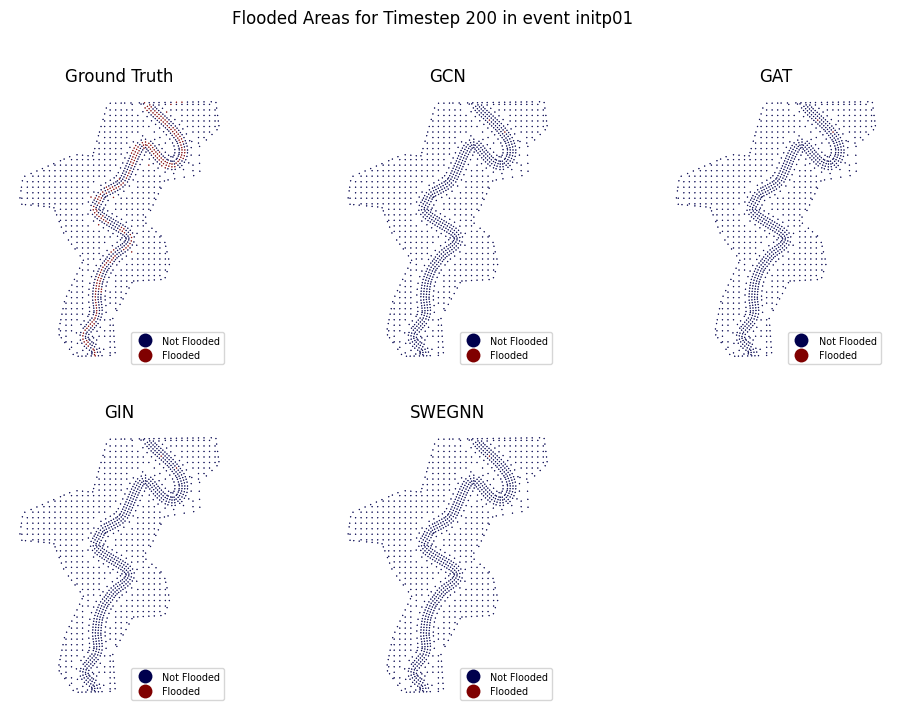

In [21]:
import geopandas as gpd

def convert_water_depth_to_binary(water_level: np.ndarray, water_threshold: float = 0.3) -> np.ndarray:
    return (water_level > water_threshold)

def plot_cell_map(axis, node_shp_path: str, water_depth: np.ndarray, title: str):
    node_df = gpd.read_file(node_shp_path)
    value_column = 'water_level'
    cmap = plt.get_cmap('seismic') 
    shared_plot_kwargs = {
        'cmap': cmap,
        'column': value_column,
        'linewidth': 0.3,
        'markersize': 0.5,
        'legend': True,
        'legend_kwds': {'loc': 'lower right', 'fontsize': 'x-small', 'labels': ['Not Flooded', 'Flooded'] },
    }
    node_df[value_column] = water_depth

    node_df.plot(ax=axis, **shared_plot_kwargs)
    axis.set_title(title)
    axis.set_axis_off()

def plot_flooded_areas_for_all_models(node_shp_path: str, metric_paths: list[str], timestep: int, ground_truth: torch.Tensor = None, water_threshold: float = 0.3):
    event_name = metric_paths[0].split('/')[-1].split('_')[1]
    ncols = 3
    num_plots = len(metric_paths) + (1 if ground_truth is not None else 0)
    nrows = (num_plots + ncols - 1) // ncols
    assert ncols * nrows >= len(metric_paths) + (1 if ground_truth is not None else 0), f"Not enough subplots for {len(metric_paths)} metrics"

    fig, ax = plt.subplots(figsize=(12,8), ncols=ncols, nrows=nrows)
    fig.suptitle(f'Flooded Areas for Timestep {timestep} in event {event_name}')
    index = 0

    if ground_truth is not None:
        binary_gt = convert_water_depth_to_binary(ground_truth[timestep, :], water_threshold)
        ax_row = index // ncols
        ax_col = index % ncols
        plot_cell_map(ax[ax_row, ax_col], node_shp_path, binary_gt, title='Ground Truth')
        index += 1

    data_shape = None
    for path in metric_paths:
        pred = np.load(path, allow_pickle=True)['pred']
        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        binary_pred = convert_water_depth_to_binary(pred[timestep, :, :].squeeze(), water_threshold)
        title = path.split('/')[-1].split('_')[0]
        ax_row = index // ncols
        ax_col = index % ncols
        plot_cell_map(ax[ax_row, ax_col], node_shp_path, binary_pred, title=title)
        index += 1

    while index < (nrows * ncols):
        ax_row = index // ncols
        ax_col = index % ncols
        ax[ax_row, ax_col].axis('off')
        index += 1

    plt.show()

TIMESTEP = 200
plot_flooded_areas_for_all_models(node_shp_path, metric_paths, timestep=TIMESTEP, ground_truth=water_depth, water_threshold=0.05)